In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 12
np.random.seed(SEED)
%matplotlib inline

Загрузиим данные.

In [4]:
data = pd.read_csv('train.csv')
data.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55


filename состоит только из имя файла, дополним его полным путем.

In [2]:
TRAIN_PATH = 'train'
TEST_PATH = 'test/test'

In [5]:
data['filename'] = data['filename'].apply(lambda x: os.path.join(TRAIN_PATH, x))
data.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,train\05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,train\04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,train\05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,train\03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,train\00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55


Добавим функцию для просмотра изображений с точками.

In [9]:
def visualize_points(img, points, radius=2, color=(255, 0, 0)):
    '''
    Рисует точки рамку на изображении img по координатам зщштеы.

    image - ndarray, матрица с изображением;
    points -  список с парами координат точек;
    radius - int, радиус, рисуемых точек.
    
    return:
    -----------------
    img - ndarray матрицы изображения с нарисованной точками.
    '''
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), radius, color=color, thickness=-1)
    return img

In [8]:
def show_image(image, points):
    '''
    Выводит изображение с ключевыми точками.

    image - ndarray, матрица с изображением;
    points -  список с парами координат точек.
    '''
    image = visualize_points(image.copy(), points, int(image.shape[0]*0.01))
    f = plt.figure(figsize=(18, 12))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()

Для аугментации и изменения размера изображения можно использовать библиотеку albumentations. Она позволяет преобразовывать одновременно с изображением и ключевые точки на нем. Точки в данной библиотеки представлены в виде [(x, y), (x, y)], поэтому добавим функцию для преобразования списка точек в список пар точек.

In [7]:
def points_to_list(points):
    '''
    Преобразует строку координат точек в список пар координат точек.
    
    points - iterable, список координат точек.
    
    return:
    -------------
    points_list - list с парами координат точек.
    '''
    points_list = []
    for i in range(0, len(points), 2):
        points_list.append((
            points[i],
            points[i+1]
        ))
    return points_list

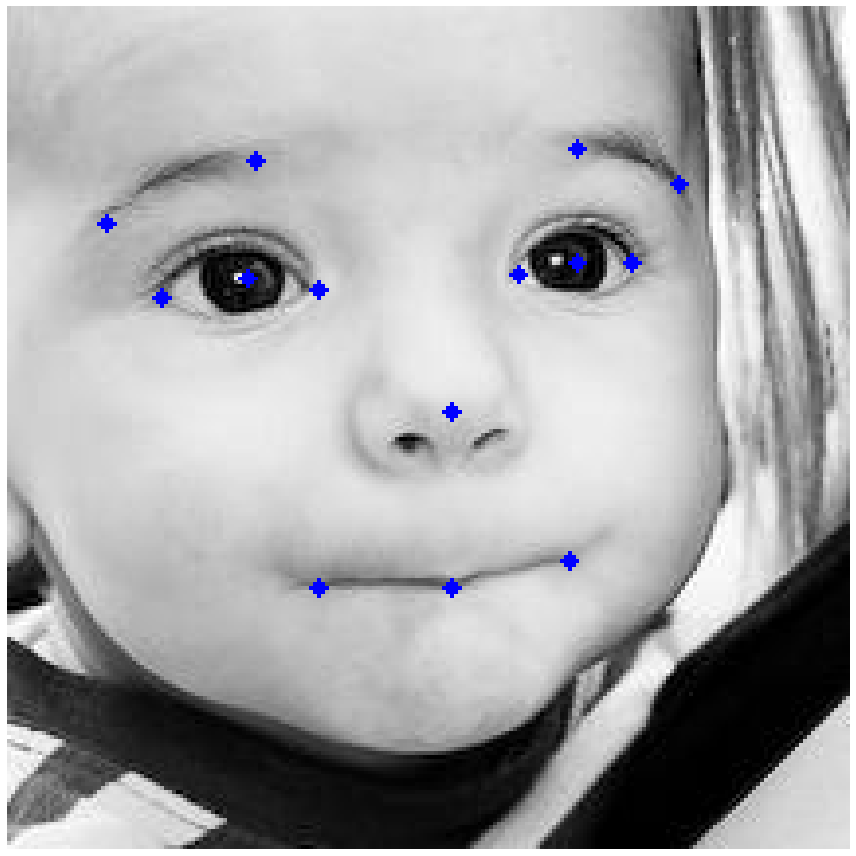

In [15]:
image = cv2.imread(data['filename'][0])
points = points_to_list(data.iloc[0, 1:])
show_image(image, points)

Имеющиеся изображения имеют разный размер, модель же на вход принимает матрицу определенного размара. Поэтому все изображения необходимо преобразовать к единому размеру.

In [6]:
# параметры представления коорлинат точек. В данном случае они булут представлены как [(x, y), (x, y), ...]
kpoint_params = A.KeypointParams(
    format='xy'
)

Возьмем для начала 128x128. Больший размер может улучшить качество предсказаний (в датасете имеются изображения достаточно большого размера), это приведет к увеличению времени обучения и работы модели. Поэтому остановимся на размере 128.

In [11]:
IMAGE_SIZE = 128

In [12]:
aug = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, always_apply=True),
], keypoint_params=kpoint_params)

In [13]:
def show_augmented(image, augmentation, points):
    '''
    Выводит изображение с применными преобразованиями.

    augmentation - преобразования изображения;
    image - ndarray изображения
    points - список пар координат точек
    '''
    augmented = augmentation(image=image, keypoints=points)
    show_image(augmented['image'], augmented['keypoints'])

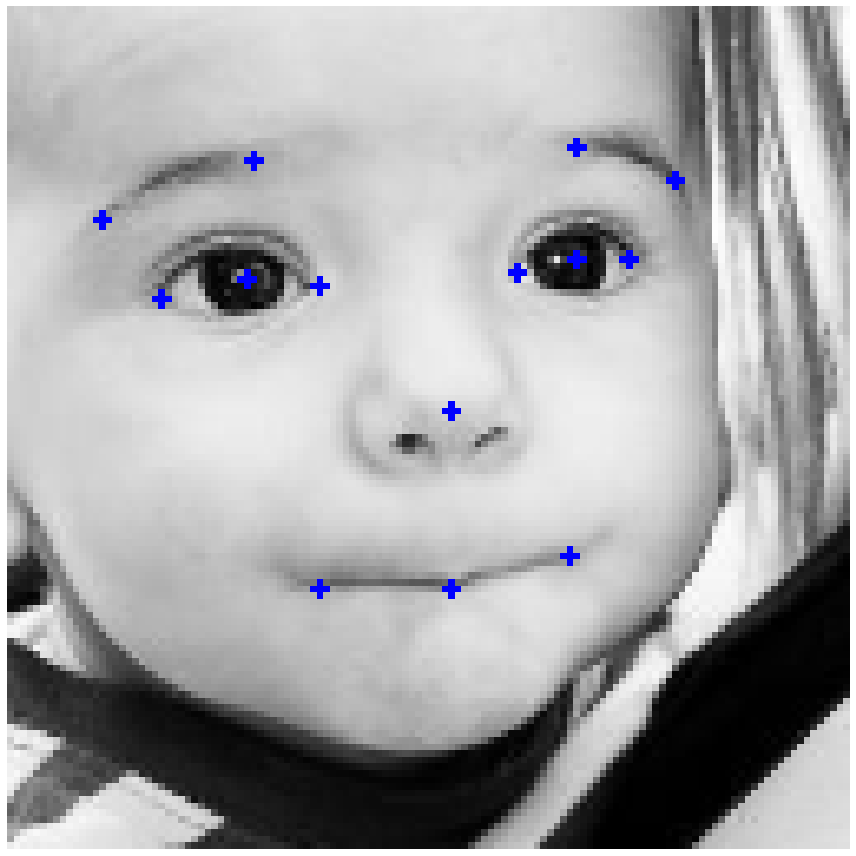

In [16]:
show_augmented(image, aug, points)

Изображение стало меньше, но положение точек все равно на месте.

Данных для обучения у нас 5000, этого может быть достаточно, но лучше увеличить их количество. Воспользуемся аугментацией изображений и сгенерируем искаженые варианты имеющихся изображений. Также координаты точек нужно отмаштабировать к интервалу [-1, 1]. Это позволит не привязывать координаты к определенному размеру изображения.

In [ ]:
def images_aug(img_path, size, keypoints, save_path, aug=None, num=3):
    '''
    Создает новые аугментированные изображения. Изображения сохраняются в
    save_path/images. DataFrame с информацией о изображениях сохраняется в
    save_path.

    aug - преобразования изображений;
    num - int, количество новых изображений на каждое исходное;
    img_path - iterable, пути к изображениям;
    labels - iterable, классы изображений;
    bboxes - iterable, ограничивающие рамки изображений;
    save_path - str, путь сохранения новых изображений.
    ---------------
    return - DataFrame с колонками [file_name, x_min, y_min, x_max, y_max, class].
    '''
    # создаем директорию для сохранения изображений, если надо
    os.makedirs(save_path, exist_ok=True)
    
    # инициируем преобразователь размера изображения
    kpoint_params = A.KeypointParams(
        format='xy'
    )
    aug_resize = A.Compose([
        A.Resize(size, size, always_apply=True),
    ], keypoint_params=kpoint_params)

    # список строк для нового DataFrame
    rows = []
    for path, points in tqdm(zip(img_path, keypoints), desc='Augmenteting images'):
        image = cv2.imread(path)
        points = points_to_list(points)
        image = aug_resize(image=image, keypoints=points)
        # маштабируем координаты точек к интервалу [-1, 1]
        points = (np.array(image['keypoints']).flatten() - size/2)/(size/2)
        points = points.tolist()
        file_name = os.path.basename(path)
        # составляем строку DataFrame и добовляем ее к остальным
        row = [file_name]
        row.extend(points)
        rows.append(row)
        # сохраняем изображение
        cv2.imwrite(os.path.join(save_path, file_name), image['image'])
        # применяем дополнительные аугментации, если нужно
        if aug:
            for i in range(num):
                augmented = aug(image=image['image'], keypoints=image['keypoints'])
                # добавляем изображение если все точки остались после аугментации
                if len(augmented['keypoints']) == len(image['keypoints']):
                    points = (np.array(augmented['keypoints']).flatten() - size/2)/(size/2)
                    points = points.tolist()
                    file_name = os.path.basename(path)
                    file_name = file_name.split('.')[0]
                    file_name = f'{file_name}_{i}.jpg'
                    row = [file_name]
                    row.extend(points)
                    rows.append(row)
                    cv2.imwrite(os.path.join(save_path, file_name), augmented['image'])
    
    # составляем названия колонок
    columns = ['filename']
    for i in range(1, len(image['keypoints'])+1):
        columns.append(f'x{i}')
        columns.append(f'y{i}')
    
    rows = pd.DataFrame(rows, columns=columns)
    rows.to_csv('annotations.csv', index=None)
    
    return rows

В качестве аугментаций будем использовать повороты и отражения, чтобы получить лица под разным наклоном.

In [ ]:
aug = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.Rotate(limit=45, p=0.8),
    A.RandomRotate90(p=0.25),
], keypoint_params=kpoint_params)

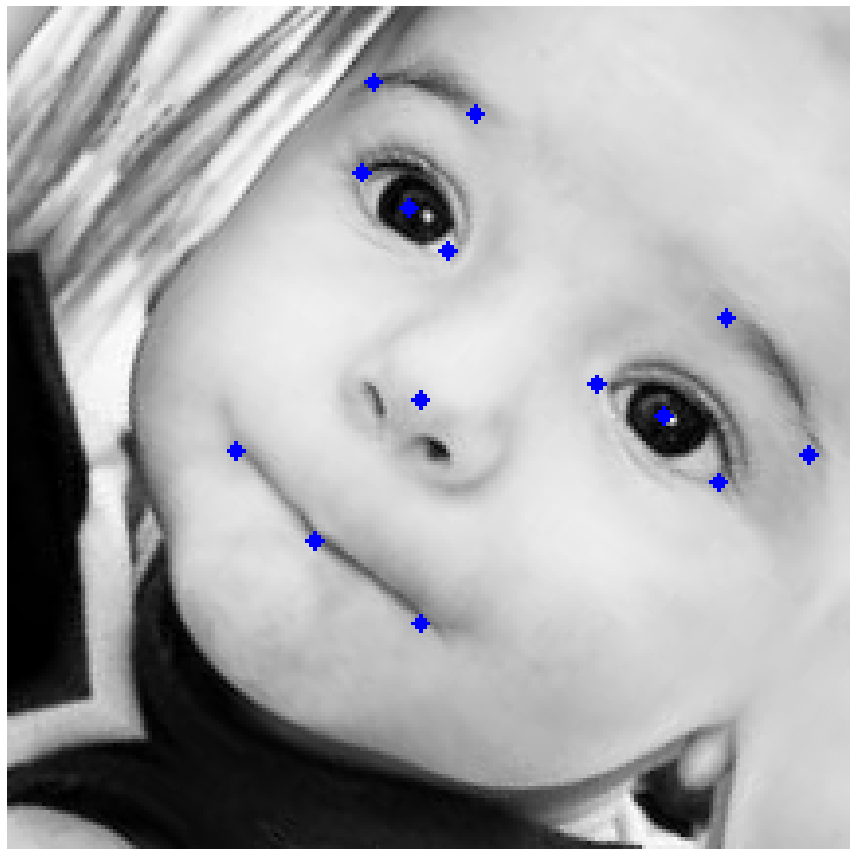

In [ ]:
show_augmented(image, aug, points)

In [17]:
SAVE_PATH = 'images'

In [ ]:
data_df = images_aug(data['filename'], 128, data.drop('filename', 1).values, SAVE_PATH, aug, 5)

Augmenteting images: 5000it [04:05, 20.39it/s]


In [19]:
data_df.head()

,filename,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13
0,05317.jpg,-0.767442,-0.488372,-0.413953,-0.637209,0.348837,-0.665116,0.590698,-0.581395,-0.637209,-0.311628,-0.432558,-0.358140,-0.265116,-0.330233,0.209302,-0.367442,0.348837,-0.395349,0.479070,-0.395349,0.051163,-0.041860,-0.265116,0.376744,0.051163,0.376744,0.330233,0.311628
1,05317_0.jpg,0.751817,-0.488372,0.398328,-0.637209,-0.364462,-0.665116,-0.606323,-0.581395,0.621584,-0.311628,0.416933,-0.358140,0.249491,-0.330233,-0.224927,-0.367442,-0.364462,-0.395349,-0.494695,-0.395349,-0.066788,-0.041860,0.249491,0.376744,-0.066788,0.376744,-0.345858,0.311628
2,05317_1.jpg,0.885907,0.088307,0.701665,-0.248088,0.121699,-0.744341,-0.119764,-0.829201,0.674004,0.145716,0.542673,-0.017984,0.394197,-0.100268,0.045833,-0.424459,-0.046077,-0.533093,-0.148059,-0.614088,-0.032819,-0.071153,-0.045490,0.453348,-0.293161,0.256646,-0.471196,0.032094
3,05317_2.jpg,0.890464,-0.040581,0.659977,-0.347146,0.014963,-0.755294,-0.236159,-0.804725,0.688957,0.046562,0.535551,-0.096658,0.376829,-0.156847,-0.014344,-0.427848,-0.120855,-0.522210,-0.233378,-0.587777,-0.041626,-0.066922,0.020893,0.453994,-0.252378,0.294760,-0.460715,0.097997
4,04767.jpg,-0.696429,-0.428571,-0.303571,-0.517857,0.000000,-0.607143,0.446429,-0.714286,-0.642857,-0.303571,-0.428571,-0.303571,-0.232143,-0.267857,0.178571,-0.410714,0.303571,-0.482143,0.535714,-0.500000,0.000000,0.178571,-0.196429,0.428571,0.053571,0.428571,0.321429,0.357143


Разобъем данные на тренировочный и тестовый ноборы. Данных стало, примерно, 20 000 и 0.2 часть их достаточна для проверки.

In [ ]:
train_df, test_df = train_test_split(data_df, train_size=.8, random_state=12)

Графические данные, обычно, занимают много места и загрузить их все в память бывает невозможно, поэтому будем использовать генератор данных. Он будет по мере обучения загружать нужные данне. Также отложим 0.2 обучающей выборки как валидационную, для проверки модели во время обучения. 

In [ ]:
datagen = ImageDataGenerator(
    validation_split=.2,
    rescale=1./255
)

Создадим для каждого набора отдельный генератор. Изображения можно не разбивать по отдельным папкам, если дать DataFrame с именами файлов соответствуюего набора.

In [50]:
train_datagen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=SAVE_PATH,
    x_col="filename",
    y_col=train_df.columns.drop('filename'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='raw',
    color_mode = "grayscale",
    batch_size=64,
    subset='training'
)

valid_datagen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=SAVE_PATH,
    x_col="filename",
    y_col=train_df.columns.drop('filename'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='raw',
    color_mode = "grayscale",
    batch_size=64,
    subset='validation'
)

test_datagen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=SAVE_PATH,
    x_col="filename",
    y_col=train_df.columns.drop('filename'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='raw',
    color_mode = "grayscale",
    batch_size=64,
)

Found 12748 validated image filenames.
Found 3187 validated image filenames.


Также создадим генератор для неразмеченных изображений. Для этих данных нет смысла создавать DataFrame с их описанием (там будет только имя файла). Вместо этого генератор может загружать все изображения из указанной папки.

In [9]:
predict_datagen = datagen.flow_from_directory(
    TEST_PATH,
    (IMAGE_SIZE, IMAGE_SIZE),
    'grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=1
)

Found 1001 images belonging to 1 classes.


# Models

Теперь можно приступать к обучению моделей. Для работы с графическими данными, обычно, используют сверточные сети. Полносвязную тоже можно использовать, но она будет иметь большое количество параметров для обучени.

Определим несколько вспомогательных функций.

In [18]:
MODELS_PATH = 'models'

In [ ]:
def plot_loss(hist):
    '''
    Строит изменение функции значения потерь модели.
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']        
    plt.plot(loss, "--", linewidth=3, label="train")
    plt.plot(val_loss, linewidth=3, label="val")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

In [ ]:
def show_image_predicted(row, model, path):
    '''
    Отображает изображение с предсказанными и истинными точками.
    Предсказанные зеленые, истинные синие.
    '''
    # открываем изображение
    filename = os.path.join(path, row['filename'])
    image = cv2.imread(filename)
    # переводим его в оттенки серого
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = image_gray[np.newaxis, ..., np.newaxis]/255
    # переводим истинные точки в исходные координаты
    true_points = row.drop('filename').values
    true_points = (true_points*IMAGE_SIZE/2 + IMAGE_SIZE/2).astype(np.uint8)
    true_points = points_to_list(true_points)
    # переводим прелсказанные точки в исходные координаты
    predicted = model.predict(image_gray)[0]
    predicted = (predicted*IMAGE_SIZE/2 + IMAGE_SIZE/2).astype(np.uint8)
    predicted = points_to_list(predicted)
    # рисуем точч=ки на изображении
    image = visualize_points(image, true_points, int(image.shape[0]*0.01), (255, 0, 0))
    image = visualize_points(image, predicted, int(image.shape[0]*0.01), (0, 255, 0))
    f = plt.figure(figsize=(18, 12))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()

Для начала построим простую сеть из сверточного слоя и полносвязного. В полносвязном слое будем испольщовать всего 32 нейрона, т.к. их увеличение сильно увеличивает количество параметров.

In [178]:
model = Sequential()
model.add(Conv2D(
    64,
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(28))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 262144)            0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                8388640   
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 28)                924       
Total params: 8,390,204
Trainable params: 8,390,204
Non-trainable params: 0
___________________________________________

In [164]:
history = model.fit(train_datagen, 
                    epochs=50,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/50
199/199 [==============================] - 10s 51ms/step - loss: 0.3141 - val_loss: 0.1369
Epoch 2/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1360 - val_loss: 0.1197
Epoch 3/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1184 - val_loss: 0.1125
Epoch 4/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1131 - val_loss: 0.1097
Epoch 5/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1125 - val_loss: 0.1089
Epoch 6/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1125 - val_loss: 0.1085
Epoch 7/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1120 - val_loss: 0.1085
Epoch 8/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1121 - val_loss: 0.1084
Epoch 9/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1121 - val_loss: 0.1086
Epoch 10/50
199/199 [==============================] - 10s 50ms/step - loss: 0.112

In [ ]:
model.save(os.path.join(MODELS_PATH, 'model_1cnn_1dense.h5'))

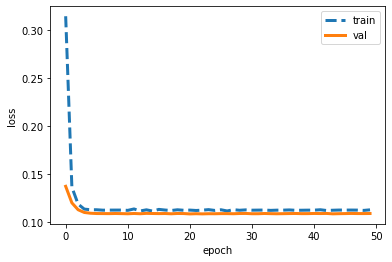

In [165]:
plot_loss(history.history)

Ошибка достаточно быстро падает до 0.11 и после перестает изменятся. Проверим модель на тестовом наборе.

In [166]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 2s 39ms/step - loss: 0.1122


0.11220339685678482

Результат не сильно отличается от валидационного. Посмотрим на результаты модели на изображении.

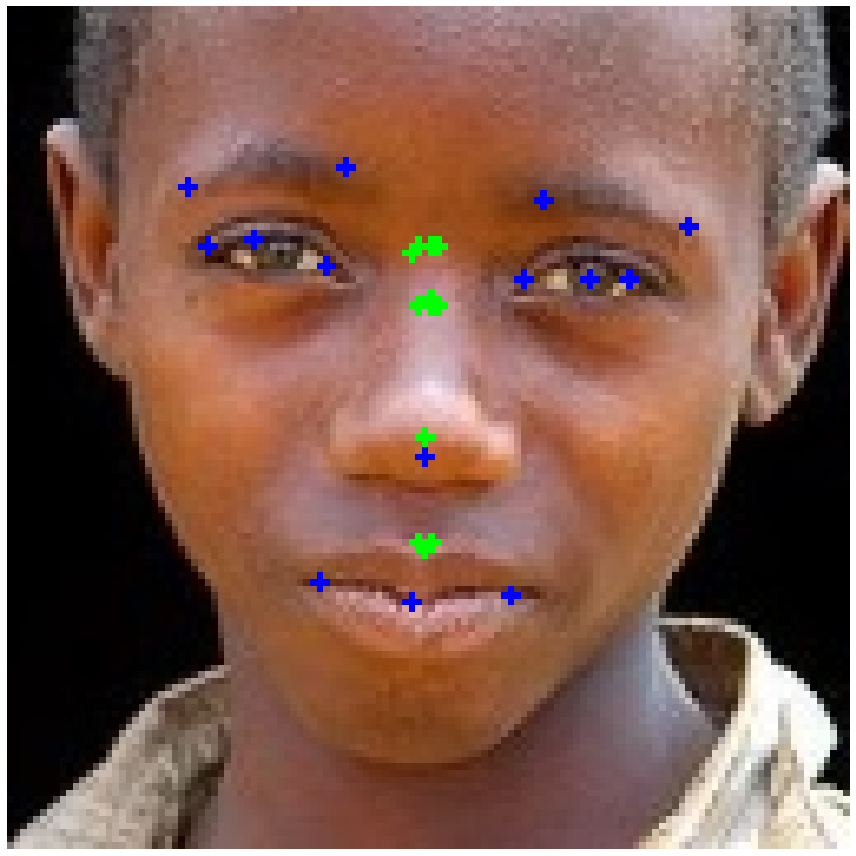

In [176]:
show_image_predicted(test_df.iloc[0], model, PATH)

Точки, предсказанные моделью (зеленые), совсем не там где нужно. Модель явно не справляется с данными. Попробуем усложнить модель. Добавим еще один сверточный слой и увеличим количество нейронов на полносвязном.

In [179]:
model = Sequential()
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(28))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)             

In [180]:
history = model.fit(train_datagen, 
                    epochs=50,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/50
199/199 [==============================] - 10s 51ms/step - loss: 0.1763 - val_loss: 0.0994
Epoch 2/50
199/199 [==============================] - 10s 51ms/step - loss: 0.1005 - val_loss: 0.0925
Epoch 3/50
199/199 [==============================] - 10s 51ms/step - loss: 0.0920 - val_loss: 0.0865
Epoch 4/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0857 - val_loss: 0.0811
Epoch 5/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0802 - val_loss: 0.0794
Epoch 6/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0757 - val_loss: 0.0784
Epoch 7/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0718 - val_loss: 0.0804
Epoch 8/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0688 - val_loss: 0.0801
Epoch 9/50
199/199 [==============================] - 10s 51ms/step - loss: 0.0653 - val_loss: 0.0793
Epoch 10/50
199/199 [==============================] - 10s 50ms/step - loss: 0.062

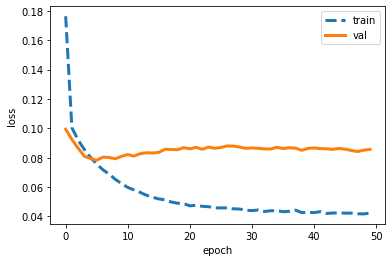

In [181]:
plot_loss(history.history)

Модель также достаточно быстро достигает наилучшего результата на валидационной выборке, но теперь ошибка на тестовой выборке продолжает падать. Значит модель уже лучше справляется с данными, хотя начинает переобучаться.

In [182]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 2s 38ms/step - loss: 0.0871


0.08705415576696396

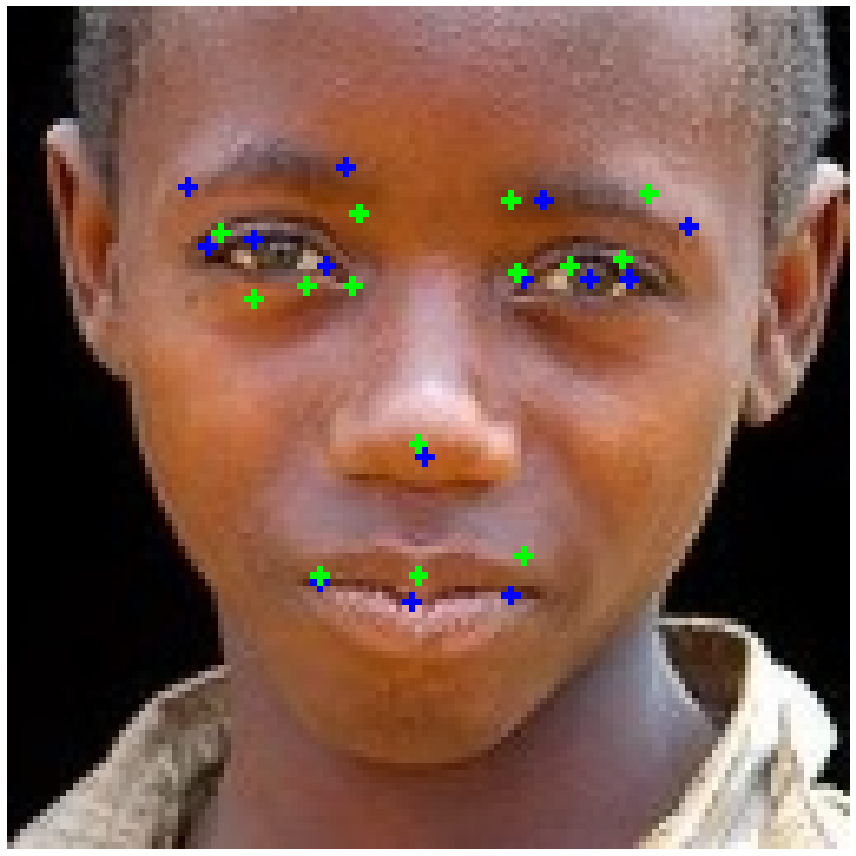

In [183]:
show_image_predicted(test_df.iloc[0], model, PATH)

In [ ]:
model.save(os.path.join(MODELS_PATH, 'model_2cnn_1dense.h5'))

Точки мдели намного ближе к истинным. Попробуем наращивать дальше количество слоев, но увеличим Dropuot. 

In [189]:
model = Sequential()
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    128, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(28))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 32768)           

Так как модель достаточно быстро доходила до своего минимума, то уменьшим количство эпох.

In [190]:
history = model.fit(train_datagen, 
                    epochs=30,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/30
199/199 [==============================] - 10s 52ms/step - loss: 0.1125 - val_loss: 0.0857
Epoch 2/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0846 - val_loss: 0.0763
Epoch 3/30
199/199 [==============================] - 10s 52ms/step - loss: 0.0753 - val_loss: 0.0720
Epoch 4/30
199/199 [==============================] - 10s 52ms/step - loss: 0.0676 - val_loss: 0.0676
Epoch 5/30
199/199 [==============================] - 10s 52ms/step - loss: 0.0624 - val_loss: 0.0660
Epoch 6/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0577 - val_loss: 0.0666
Epoch 7/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0522 - val_loss: 0.0656
Epoch 8/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0472 - val_loss: 0.0664
Epoch 9/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0411 - val_loss: 0.0674
Epoch 10/30
199/199 [==============================] - 10s 51ms/step - loss: 0.036

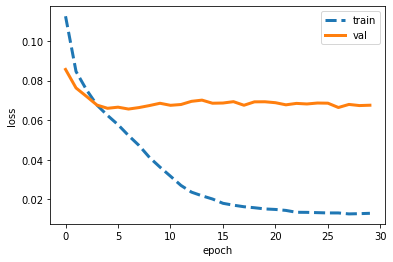

In [191]:
plot_loss(history.history)

In [192]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 2s 37ms/step - loss: 0.0687


0.06867071986198425

Модель ведет себя также, но ошибка уменьшилась. Посмотрим на изображение.

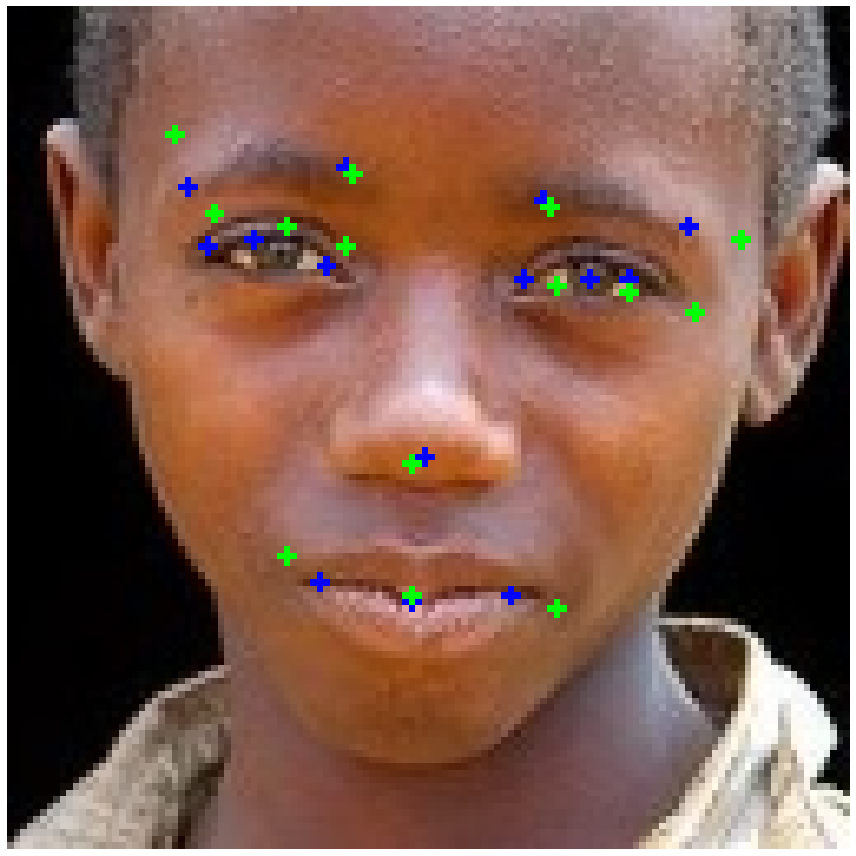

In [193]:
show_image_predicted(test_df.iloc[0], model, PATH)

In [ ]:
model.save(os.path.join(MODELS_PATH, 'model_3cnn_1dense.h5'))

На изображении точки стали ближе. Добавим дополнительный полносвязный слои. Также добавим Dropout после каждой Conv2D, чтобы уменьшить переобучения.

In [199]:
model = Sequential()
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(
    128, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(28))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 32, 32, 128)     

У меньшим количество итераций до 20 (модель всеравно в течении первых 10 итераций достигает своего минимума).

In [200]:
history = model.fit(train_datagen, 
                    epochs=20,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/20
199/199 [==============================] - 10s 52ms/step - loss: 0.1193 - val_loss: 0.0890
Epoch 2/20
199/199 [==============================] - 10s 51ms/step - loss: 0.0826 - val_loss: 0.0733
Epoch 3/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0746 - val_loss: 0.0692
Epoch 4/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0687 - val_loss: 0.0674
Epoch 5/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0666 - val_loss: 0.0657
Epoch 6/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0631 - val_loss: 0.0643
Epoch 7/20
199/199 [==============================] - 10s 51ms/step - loss: 0.0599 - val_loss: 0.0632
Epoch 8/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0580 - val_loss: 0.0626
Epoch 9/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0545 - val_loss: 0.0618
Epoch 10/20
199/199 [==============================] - 10s 51ms/step - loss: 0.052

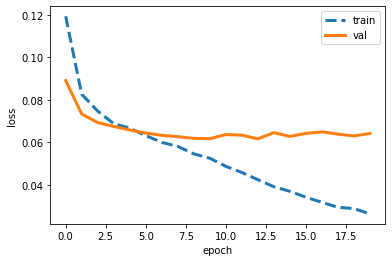

In [201]:
plot_loss(history.history)

In [202]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 2s 37ms/step - loss: 0.0657


0.06572848558425903

In [ ]:
model.save(os.path.join(MODELS_PATH, 'model_3cnn_2dense.h5'))

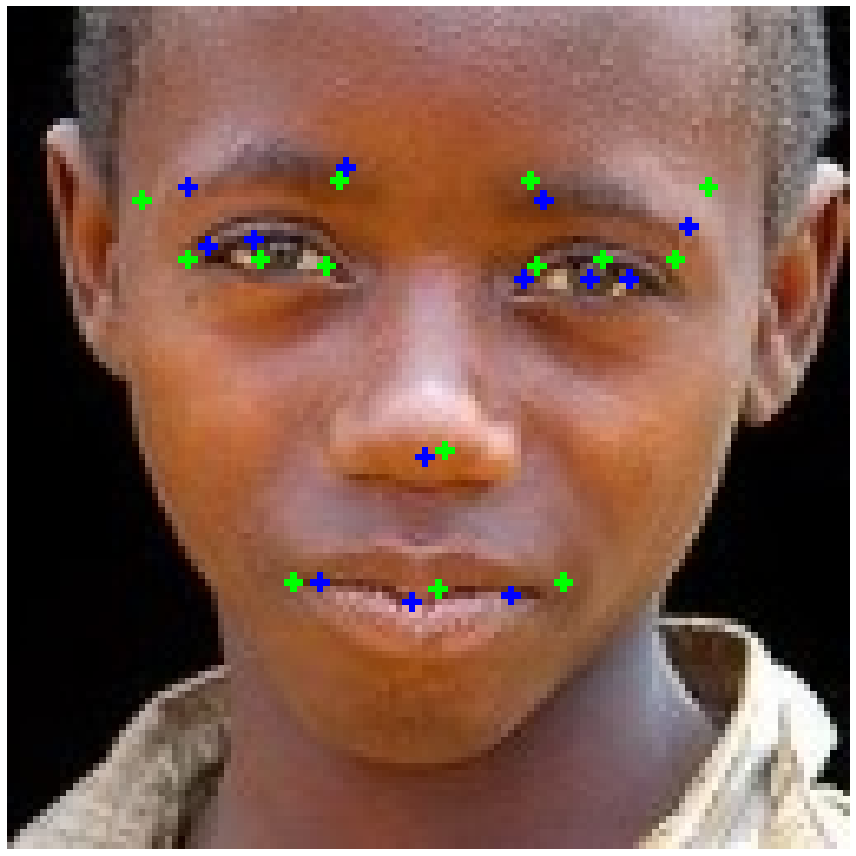

In [204]:
show_image_predicted(test_df.iloc[0], model, PATH)

Результат на валидационной подвыборке не изменился, а на тренировочной ошибка стала уменьшаться медленнее. Скорее всего дальнейшее увеличение количества слоев не приведет к значительным улучшениям качества модели, но попробуем убелиться в этом. Сделаем по два Conv2D слоя с MaxPooling2D после каждой пары. В теории большее колическтво слоев должно быть способно улавить более сложные закономерности в данных.

In [149]:
model = Sequential()
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    128, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    128, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    256, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    256, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(
    512, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    512, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten)

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(28))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_30 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_32 (Batc (None, 64, 64, 64)      

In [150]:
history = model.fit(train_datagen, 
                    epochs=50,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/50
199/199 [==============================] - 15s 77ms/step - loss: 0.4540 - val_loss: 0.1144
Epoch 2/50
199/199 [==============================] - 15s 77ms/step - loss: 0.1116 - val_loss: 0.1174
Epoch 3/50
199/199 [==============================] - 15s 76ms/step - loss: 0.1014 - val_loss: 0.1088
Epoch 4/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0955 - val_loss: 0.0968
Epoch 5/50
199/199 [==============================] - 15s 76ms/step - loss: 0.0876 - val_loss: 0.0878
Epoch 6/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0801 - val_loss: 0.0792
Epoch 7/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0751 - val_loss: 0.0734
Epoch 8/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0714 - val_loss: 0.0726
Epoch 9/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0696 - val_loss: 0.0696
Epoch 10/50
199/199 [==============================] - 15s 77ms/step - loss: 0.067

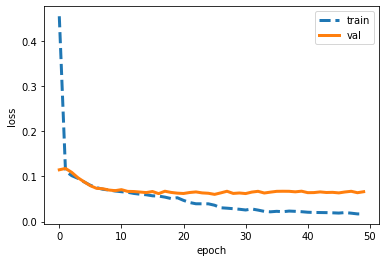

In [151]:
plot_loss(history.history)

In [153]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 3s 41ms/step - loss: 0.0649


0.0649416446685791

Как видно чтобы получить более лучшие результаты только более глубокой сети недостаточно. Остановимся на модели **model_3cnn_2dense.h5**.

# Test

Загрузим модель и получим предсказания для неразмеченных данных.

In [12]:
model = load_model(os.path.join(MODELS_PATH, 'model_3cnn_2dense.h5'))

In [13]:
predicted = model.predict(predict_datagen, verbose=1, steps=1001)

1001/1001 [==============================] - 5s 5ms/step


Преобразуем полученные предсказания в DataFrame со структурой, аналогичной train.csv.

In [ ]:
rows = []
for file, points in zip(predict_datagen.filenames, predicted):
    image = cv2.imread(os.path.join('test_data', file))
    # мнодитель для x координат
    scale_x = image.shape[1]/2
    # мнодитель для x координат
    scale_y = image.shape[0]/2
    # переволим полученные точки в координаты исходного изображения
    points[0::2] = points[0::2]*scale_x + scale_x
    points[1::2] = points[1::2]*scale_y + scale_y
    # добавляем запись к остальным
    row = [os.path.basename(file)]
    row.extend(points.astype(int).tolist())
    rows.append(row)
columns = ['filename']
for i in range(1, 15):
    columns.append(f'x{i}')
    columns.append(f'y{i}')
submission = pd.DataFrame(rows, columns=columns)

In [ ]:
submission = pd.DataFrame(predict_datagen.filenames, columns=['filename'])
xy = pd.DataFrame(predicted, columns=data_df.columns.drop('filename'))
submission = pd.concat((submission, xy))

In [16]:
submission.head(10)

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00008.jpg,19,16,34,16,50,17,64,19,22,23,28,24,33,23,50,25,55,25,61,26,40,41,28,55,39,56,50,56
1,00014.jpg,162,28,117,44,66,61,14,79,157,48,139,54,123,64,69,84,49,87,30,97,124,120,162,146,134,158,95,170
2,00015.jpg,109,62,135,58,159,60,171,64,111,82,122,83,128,82,151,85,158,83,165,86,141,136,111,178,132,181,143,180
3,00017.jpg,75,120,137,100,222,85,303,71,104,149,126,141,152,136,236,125,262,116,295,111,198,212,173,294,221,286,278,276
4,00023.jpg,1216,444,1006,446,792,468,568,513,1161,579,1088,580,1016,593,783,635,697,629,617,638,952,972,1091,1216,952,1263,797,1254
5,00029.jpg,322,295,344,241,356,199,368,157,296,292,305,268,311,264,328,213,340,194,330,185,250,264,191,322,204,290,219,257
6,00031.jpg,82,26,69,27,55,30,40,34,80,39,75,38,71,40,56,44,50,44,45,46,70,70,80,91,72,94,61,95
7,00033.jpg,1227,657,1078,508,913,347,745,185,1129,715,1048,662,993,611,810,443,766,370,698,335,743,778,692,1063,573,971,464,846
8,00037.jpg,16,34,32,27,53,21,74,15,24,42,30,38,37,37,58,32,65,29,74,27,50,55,46,77,58,74,73,70
9,00044.jpg,211,83,183,76,149,69,111,64,199,106,189,99,175,102,142,95,130,89,115,88,151,157,159,200,137,202,117,190


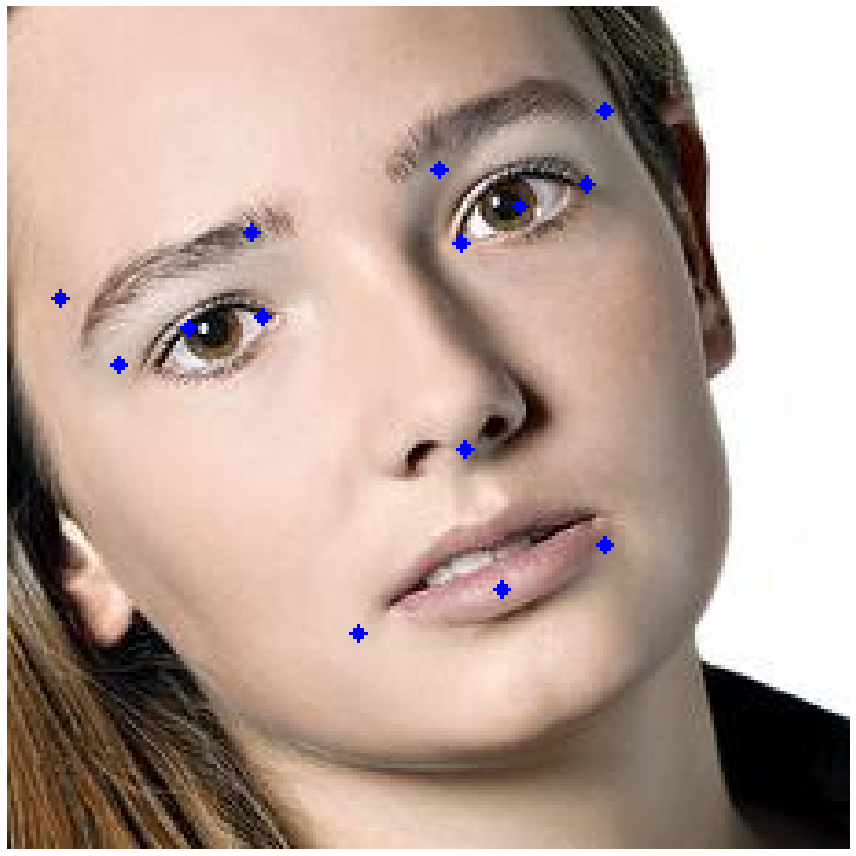

In [23]:
image = cv2.imread(os.path.join('test_data/test', submission['filename'].iloc[1]))
points = points_to_list(submission.iloc[1].drop('filename').values)
show_image(image, points)

Как видно на изображении, некоторые точки достаточно близко к реальным, но некоторые смещены.

In [ ]:
submission.to_csv('submission.csv')

Так как проблем модели в том, что она достаточно быстро достигает своего минимума и дальше ошибка не уменьшается, то улучшения дожны быть направлены на улучшение данных и архитектуры сети.
В качестве дальнейших улучшений можно попробавать увеличить размер используемых изображений (в тренировочном наборе есть достаточно большие изображения 500x500, но есть и маленькие 60x60). Это может помочь, но и на текущем изображении, для человека, различимы ключевые точки. Также можно попробовать добавить других аугментаций.

Изменить архитектуру сети. Можно использовать архитектуру на подобии ResNet.